In [ ]:
# AI Ethics Assignment  
### Fairness Audit of the COMPAS Recidivism Dataset  
#Student: Sheila Robert
#Course: AI for software development
#Tools:Pandas, Matplotlib, AI Fairness 360  
#Objective:Analyze racial bias in COMPAS risk scores and apply fairness metrics.


In [1]:
#installing libraries
!pip install aif360
!pip install pandas numpy matplotlib scikit-learn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#importing libraries dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
import pandas as pd
from aif360.datasets import BinaryLabelDataset

# Load dataset
df = pd.read_csv("compas-scores-two-years.csv")

# Drop rows with missing values 
df = df.dropna()

#alternatively, missing values can be filled  
# df = df.fillna(0)  # depending on context

# Convert to BinaryLabelDataset
compas = BinaryLabelDataset(
    df=df,
    label_names=['two_year_recid'],        # target variable
    protected_attribute_names=['race'],    # protected attribute
    favorable_label=0,
    unfavorable_label=1
)

# preview
df.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid


In [16]:
#computing fairness metrics
# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]    # Caucasian
unprivileged_groups = [{'race': 0}]  # African-American

# Create fairness metric object
metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

# Print initial metrics
print("### Fairness Metrics Before Mitigation ###")
print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact Ratio:", metric.disparate_impact())


### Fairness Metrics Before Mitigation ###
Statistical Parity Difference: -0.09713793951315464
Disparate Impact Ratio: 0.8403836674666473


In [9]:
#training model and measuring classification fairness
# Features and labels
X = dataset.features
y = dataset.labels.ravel()

# Train logistic regression
model = LogisticRegression(max_iter=200)
model.fit(X, y)

# Make predictions
pred = model.predict(X)

# Add predictions back to dataset
dataset_pred = dataset.copy()
dataset_pred.labels = pred.reshape(-1,1)

# Compute classification fairness metrics
class_metric = ClassificationMetric(
    dataset,
    dataset_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("### Classification Fairness Metrics Before Mitigation ###")
print("False Positive Rate Difference:", class_metric.false_positive_rate_difference())
print("False Negative Rate Difference:", class_metric.false_negative_rate_difference())


c:\Users\ROBERT\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Classification Fairness Metrics Before Mitigation ###
False Positive Rate Difference: -0.19918154133253008
False Negative Rate Difference: 0.07744146502949317


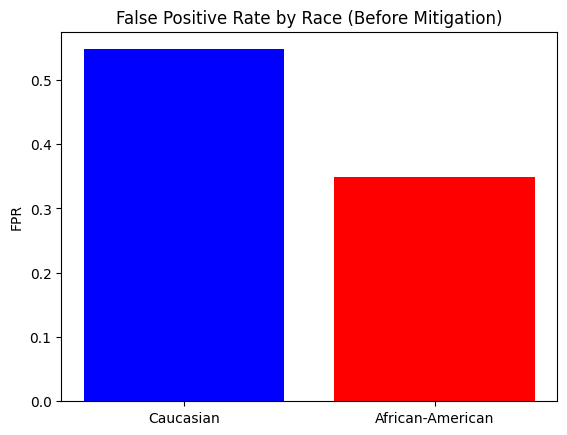

In [10]:
#visualizing the FPR by race
groups = ['Caucasian', 'African-American']
fpr = [
    class_metric.false_positive_rate(privileged=True),
    class_metric.false_positive_rate(privileged=False)
]

plt.bar(groups, fpr, color=['blue', 'red'])
plt.title("False Positive Rate by Race (Before Mitigation)")
plt.ylabel("FPR")
plt.show()


In [11]:
#applying reweighing and retraining the model
# Apply Reweighing to mitigate bias
RW = Reweighing(privileged_groups=privileged_groups,
                unprivileged_groups=unprivileged_groups)

dataset_transformed = RW.fit_transform(dataset)

# Train logistic regression on reweighed dataset
model_rw = LogisticRegression(max_iter=500)  # increased iterations
model_rw.fit(dataset_transformed.features, y)

# Predictions on reweighed dataset
pred_rw = model_rw.predict(dataset_transformed.features)

# Add predictions to dataset
dataset_transformed_pred = dataset_transformed.copy()
dataset_transformed_pred.labels = pred_rw.reshape(-1,1)

# Compute classification fairness metrics after mitigation
class_metric_rw = ClassificationMetric(
    dataset_transformed,
    dataset_transformed_pred,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

print("### Classification Fairness Metrics After Reweighing ###")
print("False Positive Rate Difference:", class_metric_rw.false_positive_rate_difference())
print("False Negative Rate Difference:", class_metric_rw.false_negative_rate_difference())


### Classification Fairness Metrics After Reweighing ###
False Positive Rate Difference: -0.20371098270142785
False Negative Rate Difference: 0.07757388347177083


c:\Users\ROBERT\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


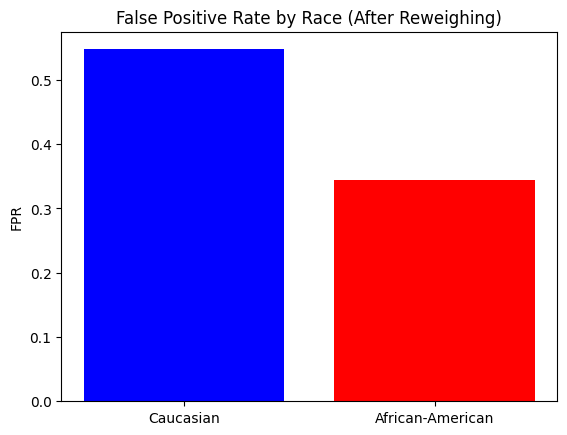

In [12]:
#visualizing FPR after reweighing
# Groups
groups = ['Caucasian', 'African-American']

# FPR after mitigation
fpr_rw = [
    class_metric_rw.false_positive_rate(privileged=True),
    class_metric_rw.false_positive_rate(privileged=False)
]

# Plot
plt.bar(groups, fpr_rw, color=['blue', 'red'])
plt.title("False Positive Rate by Race (After Reweighing)")
plt.ylabel("FPR")
plt.show()
